# Benchmark augmentation

This notebooks is do a simple benchmark around the Augmentations functions from Kornia.

Also, allow us to perform a benchmark between two rev (commit, branchs, etc) of Kornia.

Is separated into four parts:
1. **Initial setup:** 
  Here have a basic setup for this notebook, and is where we can setup some conditions for our benchmarks. Also, will be where the rev and repo owner will be chosen.
1. **Test and bench against rev_a**:
  This setup the kornia using the **rev_a** and **user_a**. Then setup the augmentations, test each one and finally run the benchmark of the augmentations chosen on `tfms_to_bench`.
1. **Test and bench against rev_b**:
  This setup the kornia using the **rev_b** and **user_b**. Then setup the augmentations, test each one and finally run the benchmark of the augmentations chosen on `tfms_to_bench`.
1. **Compare bench results**:
  The **rev** are passed as environment information for the torch benchmark, in this way, here we can compare the results between environment -- in our case, compare the results between commits, branchs, etc.


------------

### Notes 

1. The augmentations are computed using the [panda example image](https://raw.githubusercontent.com/kornia/data/main/panda.jpg).
1. If you modify some parameter of any augmentation on one of the parts (**a** or **b**) make sure to update the other part too, to be a fair benchmark.


On the [Initial setup](#Initial-Setup) you can setup somethings:

1. The kornia versions are installed using pip to install directly from the Git. 
1. If you want to benchmark/test from your fork, you will need to update the `user_<a or b>` variable.
1. If you want to change the commit/branch/etc, you will need to update the `rev_<a or b>` variable.

So the kornia for each case will be installed using the command: 
```bash
$pip install git+https://github.com/<user_a or b>/kornia.git@<rev_a or b>
```

You can setup some cases to benchmark too:
- Choose the batch sizes needed on the `batch_sizes` variable (should be a sequence of integer).
- Choose the dtypes of the input by setting the `dtypes` variable (should be a sequence of torch dtype)
- Choose the devices by setting the `devices` variable (should be sequence of torch device)
- Choose the number of threads passed to the benchmark function, by setting the `threads` variable (should be a sequence of integer)
- Choose the augmentations by setting the `tfms_to_bench` variable -- if you don't want to run some specific, you can just comment the line. This variable should be a Dict where, the key should be a string with the name of the augmentation class and the value a string of this name but in lower case.


How its works?

On both parts **rev_a** and **rev_b**, we had a `Setup the augmentations` section where each augmentation class is initialized with some default/regular values. Always matching the name of the variable with the name of the class, but using lower case for the variable name.

Each part runs the function `bench` from the initial setup. On this function, we will iterate over all cases between the batch sizes, dtypes, devices, and threads. And them, using the `torch.utils.benchmark` we will realize the benchmark, where the setup will be a import from this file of a variable with some augmentation initialized. E.g `from __main__ import randomplasmashadow`. 


After setup the variable of from where the kornia should be installed and the parameter of benchmark, and run all cells, on the final cell you should be able to see a comparison between each part. You can check if the augmentation runs as expected on the `Test each augmentation` section of each part.


# Initial Setup

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/kornia/data/main/panda.jpg

In [ ]:
from itertools import product

import matplotlib.pyplot as plt
import torch
import torch.utils.benchmark as benchmark

In [ ]:
user_a = "kornia"
rev_a = "master"  # this execution is with master on 9cd62723fa2967ca4ee9c5d855de91f4df4f46a3
user_b = "kornia"
rev_b = "9e423277f887dccaa2cd110927fef1043334e71b"

In [ ]:
batch_sizes = [1, 8]  # , 32]  # 64, 128, 256]
dtypes = [torch.float32, torch.float64]
devices = [torch.device("cpu"), torch.device("cuda")]  # ,
threads = [1]

tfms_to_bench = {
    # 'RandomPlanckianJitter': 'randomplanckianjitter', # Not working on GPU before kornia/kornia#2177
    "RandomPlasmaShadow": "randomplasmashadow",
    "RandomPlasmaBrightness": "randomplasmabrightness",
    "RandomPlasmaContrast": "randomplasmacontrast",
    "ColorJiggle": "colorjiggle",
    "ColorJitter": "colorjitter",
    "RandomBoxBlur": "randomboxblur",
    "RandomBrightness": "randombrightness",
    "RandomChannelShuffle": "randomchannelshuffle",
    "RandomContrast": "randomcontrast",
    "RandomEqualize": "randomequalize",
    "RandomGamma": "randomgamma",
    "RandomGrayscale": "randomgrayscale",
    "RandomGaussianBlur": "randomgaussianblur",
    "RandomGaussianNoise": "randomgaussiannoise",
    "RandomHue": "randomhue",
    "RandomMotionBlur": "randommotionblur",
    "RandomPosterize": "randomposterize",
    "RandomRGBShift": "randomrgbshift",
    "RandomSaturation": "randomsaturation",
    "RandomSharpness": "randomsharpness",
    "RandomSolarize": "randomsolarize",
    "CenterCrop": "centercrop",
    "PadTo": "padto",
    "RandomAffine": "randomaffine",
    "RandomCrop": "randomcrop",
    "RandomErasing": "randomerasing",
    "RandomElasticTransform": "randomelastictransform",
    "RandomFisheye": "randomfisheye",
    "RandomHorizontalFlip": "randomhorizontalflip",
    "RandomInvert": "randominvert",
    "RandomPerspective": "randomperspective",
    "RandomResizedCrop": "randomresizedcrop",
    "RandomRotation": "randomrotation",
    "RandomVerticalFlip": "randomverticalflip",
    "RandomThinPlateSpline": "randomthinplatespline",
    "RandomCutMixV2": "randomcutmixv2",
    "RandomMixUpV2": "randommixupv2",
    "RandomMosaic": "randommosaic",
    # 'RandomJigsaw': 'randomjigsaw',
}

In [ ]:
def plot_tensor(data, title=""):
    b, c, h, w = data.shape

    fig, axes = plt.subplots(1, b, dpi=100, subplot_kw={"aspect": "equal"})
    if b == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
        ax.imshow(kornia.utils.tensor_to_image(data[idx, ...]))
        ax.set_ylim(h, 0)
        ax.set_xlim(0, w)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    fig.suptitle(title)
    plt.show()


def bench(img, ref="", tfms_to_bench=tfms_to_bench, devices=devices, dtypes=dtypes, batch_sizes=batch_sizes, threads=threads):
    out = []
    for device, dtype, batch_size, thread in product(devices, dtypes, batch_sizes, threads):
        dtype_str = str(dtype).split(".")[-1]
        device_name = torch.cuda.get_device_name(0)
        print(f"{batch_size=}-dtype={dtype_str}-device={device.type}")

        inpt = img.to(device=device, dtype=dtype).repeat(batch_size, 1, 1, 1)

        for name, module in tfms_to_bench.items():
            print(f"\tBenching {name}...")
            out.append(
                benchmark.Timer(
                    stmt=f"{module}(input)",
                    label=name,
                    description=str(device.type),
                    sub_label=f"{batch_size}-{dtype_str}",
                    env=f"{ref} | torch={torch.__version__}, {device_name}",
                    setup=f"from __main__ import {module}",
                    globals={"input": inpt},
                    num_threads=thread,
                ).blocked_autorange(min_run_time=1)
            )

    return out


results = []

# Test and bench against rev_a

## Setup

In [ ]:
%%capture
!pip install git+https://github.com/$user_a/kornia.git@$rev_a
!pip install kornia_rs

In [ ]:
import kornia
from kornia.augmentation import (
    CenterCrop,
    ColorJiggle,
    ColorJitter,
    PadTo,
    RandomAffine,
    RandomBoxBlur,
    RandomBrightness,
    RandomChannelShuffle,
    RandomContrast,
    RandomCrop,
    RandomCutMixV2,
    RandomElasticTransform,
    RandomEqualize,
    RandomErasing,
    RandomFisheye,
    RandomGamma,
    RandomGaussianBlur,
    RandomGaussianNoise,
    RandomGrayscale,
    RandomHorizontalFlip,
    RandomHue,
    RandomInvert,
    RandomJigsaw,
    RandomMixUpV2,
    RandomMosaic,
    RandomMotionBlur,
    RandomPerspective,
    RandomPlanckianJitter,
    RandomPlasmaBrightness,
    RandomPlasmaContrast,
    RandomPlasmaShadow,
    RandomPosterize,
    RandomResizedCrop,
    RandomRGBShift,
    RandomRotation,
    RandomSaturation,
    RandomSharpness,
    RandomSolarize,
    RandomThinPlateSpline,
    RandomVerticalFlip,
)

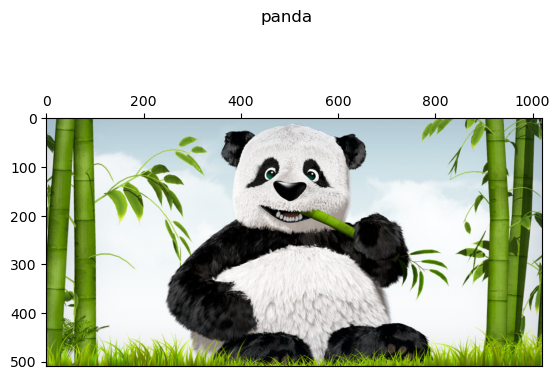

In [ ]:
img_type = kornia.io.ImageLoadType.RGB32
img = kornia.io.load_image("panda.jpg", img_type, "cpu")[None]

plot_tensor(img, "panda")

## Setup the augmentations

In [ ]:
# Intensity 2D transforms
randomplanckianjitter = RandomPlanckianJitter("blackbody", same_on_batch=False, keepdim=False, p=1.0)
randomplasmashadow = RandomPlasmaShadow(
    roughness=(0.1, 0.7), shade_intensity=(-1.0, 0.0), shade_quantity=(0.0, 1.0), same_on_batch=False, keepdim=False, p=1.0
)
randomplasmabrightness = RandomPlasmaBrightness(
    roughness=(0.1, 0.7), intensity=(0.0, 1.0), same_on_batch=False, keepdim=False, p=1.0
)
randomplasmacontrast = RandomPlasmaContrast(roughness=(0.1, 0.7), same_on_batch=False, keepdim=False, p=1.0)
colorjiggle = ColorJiggle(0.3, 0.3, 0.3, 0.3, same_on_batch=False, keepdim=False, p=1.0)
colorjitter = ColorJitter(0.3, 0.3, 0.3, 0.3, same_on_batch=False, keepdim=False, p=1.0)
randomboxblur = RandomBoxBlur((21, 21), "reflect", same_on_batch=False, keepdim=False, p=1.0)
randombrightness = RandomBrightness(brightness=(0.8, 1.2), clip_output=True, same_on_batch=False, keepdim=False, p=1.0)
randomchannelshuffle = RandomChannelShuffle(same_on_batch=False, keepdim=False, p=1.0)
randomcontrast = RandomContrast(contrast=(0.8, 1.2), clip_output=True, same_on_batch=False, keepdim=False, p=1.0)
randomequalize = RandomEqualize(same_on_batch=False, keepdim=False, p=1.0)
randomgamma = RandomGamma((0.2, 1.3), (1.0, 1.5), same_on_batch=False, keepdim=False, p=1.0)
randomgrayscale = RandomGrayscale(same_on_batch=False, keepdim=False, p=1.0)
randomgaussianblur = RandomGaussianBlur(
    (21, 21), (0.2, 1.3), "reflect", same_on_batch=False, keepdim=False, p=1.0, silence_instantiation_warning=True
)
randomgaussiannoise = RandomGaussianNoise(mean=0.2, std=0.7, same_on_batch=False, keepdim=False, p=1.0)
randomhue = RandomHue((-0.2, 0.4), same_on_batch=False, keepdim=False, p=1.0)
randommotionblur = RandomMotionBlur((7, 7), 5.0, 0.5, "reflect", "nearest", same_on_batch=False, keepdim=False, p=1.0)
randomposterize = RandomPosterize(bits=3, same_on_batch=False, keepdim=False, p=1.0)
randomrgbshift = RandomRGBShift(
    r_shift_limit=0.5, g_shift_limit=0.5, b_shift_limit=0.5, same_on_batch=False, keepdim=False, p=1.0
)
randomsaturation = RandomSaturation((0.5, 1.0), same_on_batch=False, keepdim=False, p=1.0)
randomsharpness = RandomSharpness((0.5, 1.0), same_on_batch=False, keepdim=False, p=1.0)
randomsolarize = RandomSolarize(0.1, 0.1, same_on_batch=False, keepdim=False, p=1.0)

# Geometric 2d transforms
centercrop = CenterCrop(150, resample="nearest", cropping_mode="resample", align_corners=True, keepdim=False, p=1.0)
padto = PadTo((500, 500), "constant", 1, keepdim=False)
randomaffine = RandomAffine(
    (-15.0, 5.0),
    (0.3, 1.0),
    (0.4, 1.3),
    0.5,
    resample="nearest",
    padding_mode="reflection",
    align_corners=True,
    same_on_batch=False,
    keepdim=False,
    p=1.0,
)
randomcrop = RandomCrop(
    (150, 150),
    10,
    True,
    1,
    "constant",
    "nearest",
    cropping_mode="resample",
    same_on_batch=False,
    align_corners=True,
    keepdim=False,
    p=1.0,
)
randomerasing = RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3), value=1, same_on_batch=False, keepdim=False, p=1.0)
randomelastictransform = RandomElasticTransform(
    (27, 27), (33, 31), (0.5, 1.5), align_corners=True, padding_mode="reflection", same_on_batch=False, keepdim=False, p=1.0
)
c = torch.tensor([-0.3, 0.3])
g = torch.tensor([0.9, 1.0])
randomfisheye = RandomFisheye(c, c, g, same_on_batch=False, keepdim=False, p=1.0)
randomhorizontalflip = RandomHorizontalFlip(same_on_batch=False, keepdim=False, p=1.0)
randominvert = RandomInvert(same_on_batch=False, keepdim=False, p=1.0)
randomperspective = RandomPerspective(0.5, "nearest", align_corners=True, same_on_batch=False, keepdim=False, p=1.0)
randomresizedcrop = RandomResizedCrop(
    (200, 200),
    (0.4, 1.0),
    (2.0, 2.0),
    "nearest",
    align_corners=True,
    cropping_mode="resample",
    same_on_batch=False,
    keepdim=False,
    p=1.0,
)
randomrotation = RandomRotation(15.0, "nearest", align_corners=True, same_on_batch=False, keepdim=False, p=1.0)
randomverticalflip = RandomVerticalFlip(same_on_batch=False, keepdim=False, p=1.0, p_batch=0.5)
randomthinplatespline = RandomThinPlateSpline(0.3, align_corners=True, same_on_batch=False, keepdim=False, p=1.0)

# Mix 2d transforms
randomcutmixv2 = RandomCutMixV2(1, (0.2, 0.9), same_on_batch=False, keepdim=False, p=1.0)
randommixupv2 = RandomMixUpV2((0.1, 0.9), same_on_batch=False, keepdim=False, p=1.0)
randommosaic = RandomMosaic(
    (250, 125),
    (4, 4),
    (0.3, 0.7),
    align_corners=True,
    cropping_mode="resample",
    padding_mode="reflect",
    resample="nearest",
    keepdim=False,
    p=1.0,
)
randomjigsaw = RandomJigsaw((2, 2), ensure_perm=True, same_on_batch=False, keepdim=False, p=1.0)

# List to test each one
tfms = [eval(v) for v in tfms_to_bench.values()]

## Test each augmentation

In [ ]:
num_samples = 3
for aug in tfms:
    name = type(aug).__name__
    print("->", aug)
    inpt = img.repeat(num_samples, 1, 1, 1)
    out = aug(inpt)
    plot_tensor(out, name)
    print("\n\n")

## Benchmark

In [ ]:
results_A = bench(img, rev_a)

batch_size=1-dtype=float32-device=cpu
	Benching RandomPlasmaShadow...
	Benching RandomPlasmaBrightness...
	Benching RandomPlasmaContrast...
	Benching ColorJiggle...
	Benching ColorJitter...
	Benching RandomBoxBlur...
	Benching RandomBrightness...
	Benching RandomChannelShuffle...
	Benching RandomContrast...
	Benching RandomEqualize...
	Benching RandomGamma...
	Benching RandomGrayscale...
	Benching RandomGaussianBlur...
	Benching RandomGaussianNoise...
	Benching RandomHue...
	Benching RandomMotionBlur...
	Benching RandomPosterize...
	Benching RandomRGBShift...
	Benching RandomSaturation...
	Benching RandomSharpness...
	Benching RandomSolarize...
	Benching CenterCrop...
	Benching PadTo...
	Benching RandomAffine...
	Benching RandomCrop...
	Benching RandomErasing...
	Benching RandomElasticTransform...
	Benching RandomFisheye...
	Benching RandomHorizontalFlip...
	Benching RandomInvert...
	Benching RandomPerspective...
	Benching RandomResizedCrop...
	Benching RandomRotation...
	Benching Rand

In [ ]:
compare = benchmark.Compare(results_A)
compare.print()

[------ RandomPlasmaShadow ------]
                 |   cpu   |  cuda
1 threads: -----------------------
      1-float32  |   15.2  |   3.3
      8-float32  |  199.0  |   6.6
      1-float64  |   28.9  |   3.8
      8-float64  |  489.9  |  10.7

Times are in milliseconds (ms).

[----- RandomPlasmaBrightness ----]
                 |   cpu    |  cuda
1 threads: ------------------------
      1-float32  |    54.7  |   4.0
      8-float32  |   738.7  |  13.3
      1-float64  |   129.4  |   5.4
      8-float64  |  1501.8  |  25.2

Times are in milliseconds (ms).

[------ RandomPlasmaContrast -----]
                 |   cpu    |  cuda
1 threads: ------------------------
      1-float32  |    55.1  |   3.9
      8-float32  |   755.1  |  13.3
      1-float64  |   130.2  |   5.4
      8-float64  |  1576.7  |  25.2

Times are in milliseconds (ms).

[---------- ColorJiggle ----------]
                 |   cpu    |  cuda
1 threads: ------------------------
      1-float32  |    46.8  |   3.0
     

# Test and bench against rev_b

## Setup

In [ ]:
%%capture
!pip install git+https://github.com/$user_b/kornia.git@$rev_b
!pip install kornia_rs

In [ ]:
import kornia
from kornia.augmentation import (
    CenterCrop,
    ColorJiggle,
    ColorJitter,
    PadTo,
    RandomAffine,
    RandomBoxBlur,
    RandomBrightness,
    RandomChannelShuffle,
    RandomContrast,
    RandomCrop,
    RandomCutMixV2,
    RandomElasticTransform,
    RandomEqualize,
    RandomErasing,
    RandomFisheye,
    RandomGamma,
    RandomGaussianBlur,
    RandomGaussianNoise,
    RandomGrayscale,
    RandomHorizontalFlip,
    RandomHue,
    RandomInvert,
    RandomJigsaw,
    RandomMixUpV2,
    RandomMosaic,
    RandomMotionBlur,
    RandomPerspective,
    RandomPlanckianJitter,
    RandomPlasmaBrightness,
    RandomPlasmaContrast,
    RandomPlasmaShadow,
    RandomPosterize,
    RandomResizedCrop,
    RandomRGBShift,
    RandomRotation,
    RandomSaturation,
    RandomSharpness,
    RandomSolarize,
    RandomThinPlateSpline,
    RandomVerticalFlip,
)

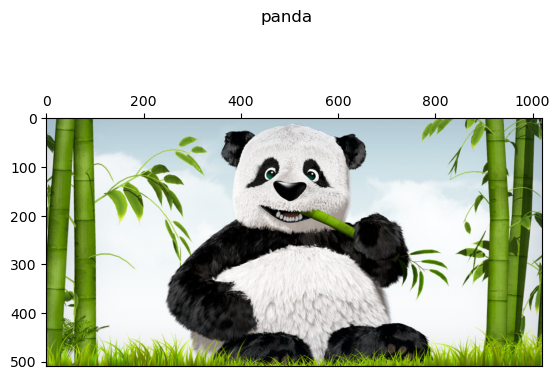

In [ ]:
img_type = kornia.io.ImageLoadType.RGB32
img = kornia.io.load_image("panda.jpg", img_type, "cpu")[None]

plot_tensor(img, "panda")

## Setup the augmentations

In [ ]:
# Intensity 2D transforms
randomplanckianjitter = RandomPlanckianJitter("blackbody", same_on_batch=False, keepdim=False, p=1.0)
randomplasmashadow = RandomPlasmaShadow(
    roughness=(0.1, 0.7), shade_intensity=(-1.0, 0.0), shade_quantity=(0.0, 1.0), same_on_batch=False, keepdim=False, p=1.0
)
randomplasmabrightness = RandomPlasmaBrightness(
    roughness=(0.1, 0.7), intensity=(0.0, 1.0), same_on_batch=False, keepdim=False, p=1.0
)
randomplasmacontrast = RandomPlasmaContrast(roughness=(0.1, 0.7), same_on_batch=False, keepdim=False, p=1.0)
colorjiggle = ColorJiggle(0.3, 0.3, 0.3, 0.3, same_on_batch=False, keepdim=False, p=1.0)
colorjitter = ColorJitter(0.3, 0.3, 0.3, 0.3, same_on_batch=False, keepdim=False, p=1.0)
randomboxblur = RandomBoxBlur((21, 21), "reflect", same_on_batch=False, keepdim=False, p=1.0)
randombrightness = RandomBrightness(brightness=(0.8, 1.2), clip_output=True, same_on_batch=False, keepdim=False, p=1.0)
randomchannelshuffle = RandomChannelShuffle(same_on_batch=False, keepdim=False, p=1.0)
randomcontrast = RandomContrast(contrast=(0.8, 1.2), clip_output=True, same_on_batch=False, keepdim=False, p=1.0)
randomequalize = RandomEqualize(same_on_batch=False, keepdim=False, p=1.0)
randomgamma = RandomGamma((0.2, 1.3), (1.0, 1.5), same_on_batch=False, keepdim=False, p=1.0)
randomgrayscale = RandomGrayscale(same_on_batch=False, keepdim=False, p=1.0)
randomgaussianblur = RandomGaussianBlur(
    (21, 21), (0.2, 1.3), "reflect", same_on_batch=False, keepdim=False, p=1.0, silence_instantiation_warning=True
)
randomgaussiannoise = RandomGaussianNoise(mean=0.2, std=0.7, same_on_batch=False, keepdim=False, p=1.0)
randomhue = RandomHue((-0.2, 0.4), same_on_batch=False, keepdim=False, p=1.0)
randommotionblur = RandomMotionBlur((7, 7), 5.0, 0.5, "reflect", "nearest", same_on_batch=False, keepdim=False, p=1.0)
randomposterize = RandomPosterize(bits=3, same_on_batch=False, keepdim=False, p=1.0)
randomrgbshift = RandomRGBShift(
    r_shift_limit=0.5, g_shift_limit=0.5, b_shift_limit=0.5, same_on_batch=False, keepdim=False, p=1.0
)
randomsaturation = RandomSaturation((0.5, 1.0), same_on_batch=False, keepdim=False, p=1.0)
randomsharpness = RandomSharpness((0.5, 1.0), same_on_batch=False, keepdim=False, p=1.0)
randomsolarize = RandomSolarize(0.1, 0.1, same_on_batch=False, keepdim=False, p=1.0)

# Geometric 2d transforms
centercrop = CenterCrop(150, resample="nearest", cropping_mode="resample", align_corners=True, keepdim=False, p=1.0)
padto = PadTo((500, 500), "constant", 1, keepdim=False)
randomaffine = RandomAffine(
    (-15.0, 5.0),
    (0.3, 1.0),
    (0.4, 1.3),
    0.5,
    resample="nearest",
    padding_mode="reflection",
    align_corners=True,
    same_on_batch=False,
    keepdim=False,
    p=1.0,
)
randomcrop = RandomCrop(
    (150, 150),
    10,
    True,
    1,
    "constant",
    "nearest",
    cropping_mode="resample",
    same_on_batch=False,
    align_corners=True,
    keepdim=False,
    p=1.0,
)
randomerasing = RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3), value=1, same_on_batch=False, keepdim=False, p=1.0)
randomelastictransform = RandomElasticTransform(
    (27, 27), (33, 31), (0.5, 1.5), align_corners=True, padding_mode="reflection", same_on_batch=False, keepdim=False, p=1.0
)
c = torch.tensor([-0.3, 0.3])
g = torch.tensor([0.9, 1.0])
randomfisheye = RandomFisheye(c, c, g, same_on_batch=False, keepdim=False, p=1.0)
randomhorizontalflip = RandomHorizontalFlip(same_on_batch=False, keepdim=False, p=1.0)
randominvert = RandomInvert(same_on_batch=False, keepdim=False, p=1.0)
randomperspective = RandomPerspective(0.5, "nearest", align_corners=True, same_on_batch=False, keepdim=False, p=1.0)
randomresizedcrop = RandomResizedCrop(
    (200, 200),
    (0.4, 1.0),
    (2.0, 2.0),
    "nearest",
    align_corners=True,
    cropping_mode="resample",
    same_on_batch=False,
    keepdim=False,
    p=1.0,
)
randomrotation = RandomRotation(15.0, "nearest", align_corners=True, same_on_batch=False, keepdim=False, p=1.0)
randomverticalflip = RandomVerticalFlip(same_on_batch=False, keepdim=False, p=1.0, p_batch=0.5)
randomthinplatespline = RandomThinPlateSpline(0.3, align_corners=True, same_on_batch=False, keepdim=False, p=1.0)

# Mix 2d transforms
randomcutmixv2 = RandomCutMixV2(1, (0.2, 0.9), same_on_batch=False, keepdim=False, p=1.0)
randommixupv2 = RandomMixUpV2((0.1, 0.9), same_on_batch=False, keepdim=False, p=1.0)
randommosaic = RandomMosaic(
    (250, 125),
    (4, 4),
    (0.3, 0.7),
    align_corners=True,
    cropping_mode="resample",
    padding_mode="reflect",
    resample="nearest",
    keepdim=False,
    p=1.0,
)
randomjigsaw = RandomJigsaw((2, 2), ensure_perm=True, same_on_batch=False, keepdim=False, p=1.0)

# List to test each one
tfms = [eval(v) for v in tfms_to_bench.values()]

## Test each augmentation

In [ ]:
num_samples = 3
for aug in tfms:
    name = type(aug).__name__
    print("->", aug)
    inpt = img.repeat(num_samples, 1, 1, 1)
    out = aug(inpt)
    plot_tensor(out, name)
    print("\n\n")

## Benchmark

In [ ]:
results_B = bench(img, rev_b)

batch_size=1-dtype=float32-device=cpu
	Benching RandomPlasmaShadow...
	Benching RandomPlasmaBrightness...
	Benching RandomPlasmaContrast...
	Benching ColorJiggle...
	Benching ColorJitter...
	Benching RandomBoxBlur...
	Benching RandomBrightness...
	Benching RandomChannelShuffle...
	Benching RandomContrast...
	Benching RandomEqualize...
	Benching RandomGamma...
	Benching RandomGrayscale...
	Benching RandomGaussianBlur...
	Benching RandomGaussianNoise...
	Benching RandomHue...
	Benching RandomMotionBlur...
	Benching RandomPosterize...
	Benching RandomRGBShift...
	Benching RandomSaturation...
	Benching RandomSharpness...
	Benching RandomSolarize...
	Benching CenterCrop...
	Benching PadTo...
	Benching RandomAffine...
	Benching RandomCrop...
	Benching RandomErasing...
	Benching RandomElasticTransform...
	Benching RandomFisheye...
	Benching RandomHorizontalFlip...
	Benching RandomInvert...
	Benching RandomPerspective...
	Benching RandomResizedCrop...
	Benching RandomRotation...
	Benching Rand

In [ ]:
compare = benchmark.Compare(results_B)
compare.print()

[------ RandomPlasmaShadow ------]
                 |   cpu   |  cuda
1 threads: -----------------------
      1-float32  |   16.0  |   3.3
      8-float32  |  199.6  |   6.4
      1-float64  |   29.3  |   3.9
      8-float64  |  473.8  |  10.7

Times are in milliseconds (ms).

[----- RandomPlasmaBrightness ----]
                 |   cpu    |  cuda
1 threads: ------------------------
      1-float32  |    56.1  |   3.9
      8-float32  |   726.2  |  13.1
      1-float64  |   126.8  |   5.4
      8-float64  |  1478.3  |  25.3

Times are in milliseconds (ms).

[------ RandomPlasmaContrast -----]
                 |   cpu    |  cuda
1 threads: ------------------------
      1-float32  |    56.5  |   3.9
      8-float32  |   739.8  |  13.1
      1-float64  |   128.9  |   5.4
      8-float64  |  1476.9  |  25.1

Times are in milliseconds (ms).

[---------- ColorJiggle ----------]
                 |   cpu    |  cuda
1 threads: ------------------------
      1-float32  |    50.1  |   2.9
     

# Compare bench results

In [ ]:
results = results_A + results_B
compare = benchmark.Compare(results)
compare.colorize()
compare.print()

[------------------------------------------------ RandomPlasmaShadow -----------------------------------------------]
                                                                                                    |   cpu   |  cuda
1 threads: ----------------------------------------------------------------------------------------------------------
  (9e423277f887dccaa2cd110927fef1043334e71b | torch=1.13.1, NVIDIA GeForce RTX 3060 Ti)  1-float32  |   16.0  |   3.3
                                                                                         8-float32  |  199.6  |   6.4
                                                                                         1-float64  |   29.3  |   3.9
                                                                                         8-float64  |  473.8  |  10.7
  (master | torch=1.13.1, NVIDIA GeForce RTX 3060 Ti)                                    1-float32  |   15.2  |   3.3
                                                        